# Final Exam

## FINM 37400 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

# Instructions

## Please note the following:

Time
* You have 180 minutes to complete the exam.
* For every minute late you submit the exam, you will lose one point.

Submission
* You will upload your solution to the Final Exam assignment on Canvas.
* Your submission should be readable, (the graders can understand your answers,) and it should include all code used in your analysis in a file format that the code can be executed. (ie. .ipynb preferred, .pdf is unacceptable.)

Rules
* The exam is open-material, closed-communication.
* You do not need to cite material from the course github repo--you are welcome to use the code posted there without citation, (only for this exam.)

Advice
* If you find any question to be unclear, state your interpretation and proceed. We will only answer questions of interpretation if there is a typo, error, etc.
* The exam will be graded for partial credit.

## Data

**All data files are found in the class github repo, in the `data` folder.**

This exam makes use of the following data files:

#### Section 2
* New file: `select_maturities_2017-02-07.xlsx`

#### Section 3
* Familiar file: `famabliss_strips_2023-12-29.xlsx`

## Scoring

| Problem | Points |
|---------|--------|
| 1       | 25     |
| 2       | 45     |
| 3       | 60     |
| 4       | 35     |
| **Total**   | **165**|

In [1]:
#Necessary functions and imports

from scipy import optimize as opt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression


def continuous_from_discount(discount, maturity):
    '''Returns the continuous rate from the discount factor and the maturity'''
    return -np.log(discount)/maturity

def compounded_from_discount(discount, maturity, freq=2):
    '''Returns the compounded rate from the discount factor and the maturity'''
    return ((1/discount)**(1/(maturity*freq))-1)*freq

def discount_from_continuous(continuous, maturity):
    '''Returns the discount factor from the continuous rate and the maturity'''
    return np.exp(-continuous*maturity)

def discount_from_compounded(compounded, maturity, freq=2):
    '''Returns the discount factor from the compounded rate and the maturity'''
    return (1+compounded/freq)**(-maturity*freq)

def BootstrapData(df, maturities='maturity date', bid='bid', ask='ask'):
    '''Returns a dataframe with the minimum bid-ask spread for each bond maturity in the dataset.
    Specify maturity date column, bid column and ask column as strings.'''
    dates = df[maturities].unique()
    dates=pd.to_datetime(dates)
    df['bas']=(df[bid]+df[ask])
    tdf=pd.DataFrame(columns=df.columns)
    for i in dates:
        dfi = df[df[maturities]==i].copy()
        idx = dfi['bas'].idxmin()
        tdf.loc[len(tdf)] = dfi.loc[idx]
    tdf.drop(columns=['bas'], inplace=True)
    return tdf

def C_matrix(fdf, date, maturity_col, id_col, coupon_col, freq):
    '''Returns a dataframe with the cash flows of each bond in the dataset. Rounds to end of the month
    if less than 5 days away.
    date: string with to calculate cash flows from. Format: 'YYYY-MM-DD'
    maturity_col: string with the name of the column with the maturity date
    id_col: string with the name of the column with the bond id
    coupon_col: string with the name of the column with the coupon rate
    freq: integer with the number of coupon payments per year
    fdf: dataframe with the bond data'''
    tCdf = []
    for i in range(len(fdf)):
        row_data = {}
        crspid = fdf.iloc[i][id_col]
        maturity = pd.to_datetime(fdf.iloc[i][maturity_col]).strftime('%Y-%m-%d')
        coupon = fdf.iloc[i][coupon_col]
        row_data[id_col] = crspid
        row_data[(pd.to_datetime(maturity)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')] = 100 + (coupon / freq)
        maturity = pd.to_datetime(maturity) - pd.DateOffset(months=int(12/freq))
        while maturity > pd.to_datetime(date):
            tmat = maturity
            if pd.to_datetime(maturity).day > pd.to_datetime(maturity+pd.offsets.MonthEnd(0)).day-20:
                tmat = tmat + pd.offsets.MonthEnd(0)
            row_data[tmat.strftime('%Y-%m-%d')] = coupon / freq
            maturity = maturity - pd.DateOffset(months=int(12/freq))
        tCdf.append(row_data)
    return pd.DataFrame(tCdf).set_index(id_col,drop=True).sort_index(axis=1).fillna(0)

def macDuration(ytm, c, ttm, freq=2):
    ''' MacaulayDuration based on yield-to-maturity [absolute value], coupon [%], 
    time-to-maturity [years] and frequency [periods per year]'''
    tp=0
    tt=((ttm*freq)-int(ttm*freq))/freq
    tpp=0
    if tt == 0:
        tp-=c/freq
    while tt < ttm:
        tp+=(c/freq)*(1/((1+(ytm/freq))**(tt*freq)))
        tpp+=tt*(c/freq)*(1/((1+(ytm/freq))**(tt*freq)))
        tt+=1/freq
    tp+=(100+(c/freq))*(1/((1+(ytm/freq))**(ttm*freq)))
    tpp+=ttm*(100+(c/freq))*(1/((1+(ytm/freq))**(ttm*freq)))
    return tpp/tp

def get_price(yield_, maturity, coupon, freq=2):
    '''Price based on yield [absolute value], maturity [years], coupon [%], 
    and frequency [periods per year]'''
    tp=0
    tt=((maturity*freq)-int(maturity*freq))/freq
    if tt == 0:
        tp-=coupon/freq
    while tt < maturity:
        tp+=(coupon/freq)/(((1+(yield_/freq))**(freq*tt)))
        tt+=1/freq
    tp+=(100+(coupon/freq))/((1+(yield_/freq))**(maturity*freq))
    return tp

def get_yield(price, maturity, coupon, freq=2):
    '''Yield based on price [currency], maturity [years] and coupon [%]'''
    def bond_price(yield_):
        tp=0
        tt=((maturity*freq)-int(maturity*freq))/freq
        if tt == 0:
            tp-=coupon/freq
        while tt < maturity:
            tp+=(coupon/freq)/(((1+(yield_/freq))**(freq*tt)))
            tt+=1/freq
        tp+=(100+(coupon/freq))/((1+(yield_/freq))**(maturity*freq))
        return price-tp
    return opt.root(bond_price, 0.02).x[0]/365.25

def estimate_ns(*args):
    '''Make sure first argument is the C matrix (columns are times and rows are issues) and the second argument is a dataframe with a "price" column and same index.
    Results are called through the .x attribute of the returned object. 0 is t0, 1 is t1, 2 is t2, and 3 is lambda.'''
    def estimate_ns(params, *args):
        M, tba = args[0], args[1]
        t0, t1, t2, lam = params[0], params[1], params[2], params[3]
        tM=M.copy()
        times=tM.columns
        times=(pd.to_datetime(times)-pd.to_datetime('2023-07-23')).days/365.25
        tM.columns=times
        error=0
        for i in tM.index:
            price=0
            tM.loc[i][tM.loc[i]>0].index
            for ii in tM.loc[i][tM.loc[i]>0].index:
                rate=t0+((t1+t2)*((1-np.exp(-ii/lam))/(ii/lam)))-t2*np.exp(-ii/lam)
                price+=tM.loc[i,ii]*np.exp(-rate*ii)
            error+=(price-tba.loc[i,'price'])**2
        return error
    return opt.minimize(estimate_ns, [0.01, 0.01, 0.01, 1], args=(args), method='L-BFGS-B')

***

# 1. Long-Short Trades

Consider the following market data as of `Dec 29, 2023`.

The table below shows two Treasury securities, a T-note and a T-bond. They mature on the same date.

In [2]:
import pandas as pd
summary = pd.DataFrame(index=[],columns = [207391,204095],dtype=float)
summary.loc['issue date'] = ['2019-08-15','1999-08-15']
summary.loc['maturity date'] = ['2029-08-15','2029-08-15']
summary.loc['coupon rate'] = [.01625, .06125]
summary.loc['clean price'] = [89.03125,111.0391]
summary.loc['accrued interest'] = [.6005, 2.2636]
summary.loc['ytm'] = [.037677, .038784]
summary.loc['duration'] = [5.3494,4.7967]
summary

,207391,204095
issue date,2019-08-15,1999-08-15
maturity date,2029-08-15,2029-08-15
coupon rate,0.01625,0.06125
clean price,89.03125,111.0391
accrued interest,0.6005,2.2636
ytm,0.037677,0.038784
duration,5.3494,4.7967


### 1.1. (5pts)

Explain the long-short trade you would enter based on the market data above, without any further calculation. 

The instruments mature on the same date, yet their ytm are different. The bond ytm is higher (3.87%) meaning that it currently has a lower price than the note (with a ytm of 3.76%). Ytm can be rationalized as the return if held to maturity. Consequently, one should short the expensive instrument, in this case the T-note, and long the inexpensive instrument, in this case the T-bond.

Short note

Long bond

### 1.2. (5pts)

Size your trade.
* Suppose the long side is set to $100 million market value. 
* Size the short to be duration-neutral.

Report the market value in the short-side of the trade and the number of long and short contracts.

In [3]:
note=207391 #short
bond=204095 #long
nlong=100/summary.loc['clean price'][bond] #number of bonds to buy in millions
ddlong=summary.loc['duration'][bond]*summary.loc['clean price'][bond]
ddshort=summary.loc['duration'][note]*summary.loc['clean price'][note]
nshort=-nlong*ddlong/ddshort
print('Number of notes to short [in million] :', round(nshort,3))
print('Market value of short position [in million] :', round(nshort*summary.loc['clean price'][note],3))


Number of notes to short [in million] : -1.007
Market value of short position [in million] : -89.668


### 1.3. (5pts)

What are the risks of this trade in the short-term and in the long-term?

At maturity the instruments' ytm are expected to converge (largely, disregarding any minor microstructure and other ancillary marginal impacts). Nonetheless, that is only an expected relationship at maturity. In the short term, it may be the case that ytm move in any direction do to market pressures, which may affect (either positively or negatively) the performance of the trade. In particular, it would be possible for the ytm of the bond to decrease below the ytm in the note relatively, reversing the position of our suggested trade, or resulting in loses.

### 1.4. (5pts)

Use **modified duration**--not the Macauley duration reported above--to estimate how much pnl will be earned if the securities converge (symmetrically).

In [4]:
#Assuming semianual
mdurlong=summary.loc['duration'][bond]/(1+summary.loc['ytm'][bond]/2)
mdurshort=summary.loc['duration'][note]/(1+summary.loc['ytm'][note]/2)
spread = summary.loc['ytm'][bond]-summary.loc['ytm'][note]
long_pnl=1000000*nlong*mdurlong*spread*summary.loc['clean price'][bond]/2
short_pnl=-1000000*nshort*mdurshort*spread*summary.loc['clean price'][note]/2
print('Long position, pnl [USD]: ', round(long_pnl, 2))
print('Long position, pnl [USD]: ', round(short_pnl, 2))
print('Total pnl [USD]: ', round(long_pnl+short_pnl, 2))

Long position, pnl [USD]:  260446.76
Long position, pnl [USD]:  260588.25
Total pnl [USD]:  521035.01


### 1.5. (5pts)

For which of these securities will the duration approximation be less accurate? Explain.

Duration-approximated price will be more accurate for bonds where the convexity term is small (i.e. larger coupons).

The duration approximation will be **less accurate** for the **note**, which has a lower coupon payment than the bond but the same maturity (i.e. higher convexity).

***

# 2. Extracting Curves

Use the selected treasury quotes in the file, `select_maturities_2017-02-07.xlsx`.

* Market quots are provided for treasury securities expiring approximately every six months over the next ten years.
* You are welcome to assume that they mature at exaclty six-year increments or to use the exact dates.
* Consider the `price` column to represent the dirty mid price. Use it as quoted, without further adjustment.

In [5]:
df=pd.read_excel("../data/select_maturities_2017-02-07.xlsx")
df['price']=((df['bid']+df['ask'])/2)+df['accrint']

### 2.1 (10pts)

Bootstrap the spot curve. Report it in both...
* discount factors, $Z$
* (semiannually compounded) discount rates, $r$

In [6]:
C=C_matrix(BootstrapData(df), '2017-02-07','maturity date','kytreasno','cpn rate',2)
C=C.iloc[:,1:].copy()
tprices=df.set_index('kytreasno',drop=True).loc[C.index]['price']
model=LinearRegression(fit_intercept=False)
model.fit(C,tprices)
res=pd.DataFrame({'discount_factor':model.coef_,'maturity':(pd.to_datetime(C.columns)-pd.to_datetime('2017-02-07')).days/365.25}).set_index('maturity',drop=True)
res['semiannual']=compounded_from_discount(res['discount_factor'], res.index, 2)
res

,discount_factor,semiannual
maturity,,
0.561259,0.999288,0.001269
1.056810,0.994393,0.005327
1.560575,0.987643,0.007984
2.056126,0.982836,0.008438
2.559890,0.974284,0.010203
3.058179,0.962927,0.012391
3.561944,0.951387,0.014040
4.057495,0.938024,0.015831
4.561259,0.926485,0.016811


### 2.2 (10pts)

Calculate the Nelson-Siegel curve using the parameters below. (Not the NS-extended; just four parameters.)

Report both
* discount factors, $Z$
* (semiannually compounded) discount rates, $r$

In [7]:
params = pd.DataFrame(columns=['Nelson-Siegel parameters'],index=['theta0', 'theta1','theta2','lambda1'],data=[0.031627,-0.025166, -0.020701, 1.514887]).T
display(params)

,theta0,theta1,theta2,lambda1
Nelson-Siegel parameters,0.031627,-0.025166,-0.020701,1.514887


In [8]:
t0=params.loc['Nelson-Siegel parameters']['theta0']
t1=params.loc['Nelson-Siegel parameters']['theta1']
t2=params.loc['Nelson-Siegel parameters']['theta2']
lam=params.loc['Nelson-Siegel parameters']['lambda1']
res['NS_rate']=t0+((t1+t2)*((1-np.exp(-res.index/lam))/(res.index/lam)))-t2*np.exp(-res.index/lam)
res['NS_discount']=discount_from_continuous(res['NS_rate'], res.index)
res['NS_semiannual']=compounded_from_discount(res['NS_discount'], res.index, 2)
res
#NS_semiannual for semiannually compounded rates
#NS_discount for discount factors


,discount_factor,semiannual,NS_rate,NS_discount,NS_semiannual
maturity,,,,,
0.561259,0.999288,0.001269,0.007590,0.995749,0.007604
1.056810,0.994393,0.005327,0.008911,0.990627,0.008931
1.560575,0.987643,0.007984,0.010385,0.983924,0.010412
2.056126,0.982836,0.008438,0.011858,0.975913,0.011894
2.559890,0.974284,0.010203,0.013314,0.966493,0.013358
3.058179,0.962927,0.012391,0.014674,0.956117,0.014728
3.561944,0.951387,0.014040,0.015950,0.944772,0.016013
4.057495,0.938024,0.015831,0.017100,0.932970,0.017173
4.561259,0.926485,0.016811,0.018163,0.920492,0.018246


### 2.3 (5pts)

Plot...
* bootstrapped spot rates
* Nelson-Siegel spot rates
* provided ytm

In [9]:
res['ytm']=df['ytm'].values

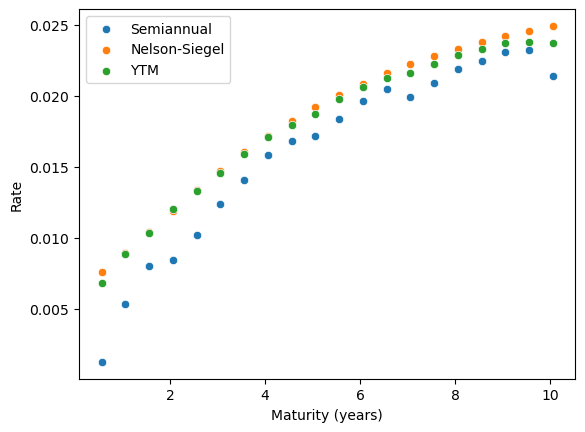

In [10]:
sns.scatterplot(x=res.index, y=res['semiannual'], label='Semiannual')
sns.scatterplot(x=res.index, y=res['NS_semiannual'], label='Nelson-Siegel')
sns.scatterplot(x=res.index, y=res['ytm'], label='YTM')
plt.xlabel('Maturity (years)')
plt.ylabel('Rate')
plt.legend()
plt.show()

### 2.4 (10pts)

Which of the two spot rate curves (bootstrapped or Nelson-Siegel) would be better for...
* pricing the provided sample
* building spot rates out to 30 years
* calculating forward rates

For each of these three questions, be **specific** in your answer.

* pricing the provided sample

For the provided sample only, the bootstrapped version would be better. It does not generalize as well for other datapoints, but for in-sample, we are not imposing the bias that the NS parametric approach imposes, so the bootstrapped version would perform better.

* building spot rates out to 30 years

For building spot rates out the NS approach would be better. For any out-of-sample predictions the NS approach increases the statistical power by only selected a small number of parameters describing all the datapoint. In general, they are not priced perfectly, but the statistical power of the model greatly increases.

* calculating forward rates

The Nelson-Siegel model is also preferable for calculating forward rates, especially over longer horizons. Its smooth, continuous curve facilitates the derivation of forward rates from spot rates. While bootstrapping can calculate forward rates, the Nelson-Siegel model's functional form can more easily capture the term structure's overall shape, providing a coherent framework for forwards over various maturities.


### 2.5 (5pts)

Consider the bootstrapped curve and its associated forward curve. (No need to calculate the forward curve.)

Conceptually, do you expect it is higher or lower than the spot-rate curve at
* $T=1$
* $T=10$

Explain.

The question is whether the curve is essentially increasing or decreasing at that point. For T=1, the curve is increasing, we therefore expect the forward curve to be higher. For T=10, there seems to be a pretty substantial dip. Consequently, we expect that forward rate to be lower that the spot-rate curve.

### 2.6 (5pts)

Use the bootstrapped spot curve to calculate the forward rate for $T_1=3\to T_2=3.5$.

In [11]:
res.index=np.arange(0.5,10.5,0.5)
forwardrate=continuous_from_discount(res.loc[3.5,'discount_factor']/res.loc[3, 'discount_factor'], 0.5)
print('Forward rate: ', round(forwardrate*100, 2), '%')

Forward rate:  2.41 %


***

# 3. Trading the Yield Curve



Use the file, `famabliss_strips_2023-12-29.xlsx` for the following problem.

* The file provides prices for **strips** which are zero-coupon bonds. 
* Assume face value of 100.
* Because these prices are on zero-coupon bonds, they can be interpreted as discount factors, $Z$, directly.

Note that you will make use of only a few rows of the data set.

In [12]:
dfs=pd.read_excel("../data/famabliss_strips_2023-12-29.xlsx")
dfs

,date,1,2,3,4,5
0,1952-06-30,98.177763,96.253133,94.246713,92.634134,90.418295
1,1952-07-31,98.094756,96.031453,93.931226,92.308865,89.851576
2,1952-08-29,98.057808,95.974988,93.781939,92.145776,89.571687
3,1952-09-30,98.031188,95.909789,93.755108,92.096104,89.167641
4,1952-10-31,98.110769,95.974490,93.758273,91.929019,89.724841
...,...,...,...,...,...,...
854,2023-08-31,94.816353,90.853466,87.433461,84.104382,81.043140
855,2023-09-29,94.730925,90.527697,86.825311,83.080264,79.615657
856,2023-10-31,94.771792,90.435524,86.473944,82.436256,78.612617
857,2023-11-30,95.107986,91.195087,87.695668,84.219066,80.937758


### 1. (10pts)

Set up a trade as of `2010-01-29` to 
* go long 100 million (market value) of the 5-year.
* short the 2-year strips in a quantity that is duration hedged.

List the positions you hold long and short. 
* Assume you are financing the positions directly; no worries about haircuts. 
* Assume there are no market frictions, so you can short securities and immediately receive their market value. 
* (No need to worry about borrowing costs for the short.)

In [13]:
fact=dfs[dfs['date']=='2010-01-29']
fact

,date,1,2,3,4,5
691,2010-01-29,99.688332,98.431098,96.079773,92.897235,88.898332


In [14]:
nnlong=(100/fact[5]).values[0] #number of bonds to buy in millions
dddlong=5*fact[5].values[0]
dddshort=2*fact[2].values[0]
nnshort=-nnlong*dddlong/dddshort
print('Number of instruments long [in million] :', round(nnlong,3))
print('Market value of long position [in million] :', round(nnlong*fact[5].values[0],3))
print(' ')
print('Number of instruments short [in million] :', round(nnshort,3))
print('Market value of short position [in million] :', round(nnshort*fact[2].values[0],3))



Number of instruments long [in million] : 1.125
Market value of long position [in million] : 100.0
 
Number of instruments short [in million] : -2.54
Market value of short position [in million] : -250.0


### 2. (5pts)
As of `2011-01-31`, assess the pnl on the long, short, and net trade.

In [15]:
fact2=dfs[dfs['date']=='2011-01-31']
fact2

,date,1,2,3,4,5
703,2011-01-31,99.689175,98.927488,97.128458,94.391538,90.614294


In [16]:
print('Long:')
marketV2l=nnlong*fact2[4].values[0]
pnlL=nnlong*(fact2[4].values[0]-fact[5].values[0])
print('Market value of long position [in million] :', round(marketV2l,3))
print('PnL [in million] :', round(pnlL,3))
print(' ')
print('Short:')
marketV2s=nnshort*fact2[1].values[0]
pnlS=nnshort*(fact2[1].values[0]-fact[2].values[0])
print('Market value of short position [in million] :', round(marketV2s,3))
print('PnL [in million] :', round(pnlS,3))
print(' ')
tot=pnlL+pnlS
print('Total PnL [in million] :', round(tot,3))

Long:
Market value of long position [in million] : 106.179
PnL [in million] : 6.179
 
Short:
Market value of short position [in million] : -253.195
PnL [in million] : -3.195
 
Total PnL [in million] : 2.984


### 3. (10pts)
On `2011-01-31`, roll over the trade.
* close out the short positions
* enter new short positions in 2-year strips that are a duration hedge against your (continuing) long positions.

List the details of your short and long positions in terms of market value and face value of each side of the trade.

In [17]:
print('Closing short position: [million]', round(marketV2s,3))

ndddlong=4*marketV2l

new_ddur_short=2*fact2[2].values[0]

new_nshort=-ndddlong/new_ddur_short
print('Number of new instruments short [in million] :', round(new_nshort,3))

new_marketVs=new_nshort*fact2[2].values[0]
print('Market value of new short position [in million] :', round(new_marketVs,3))

print('Long: ')
print('Number of instruments long [in million] :', round(nnlong,3))
print('Market value of long position [in million] :', round(marketV2l,3))


Closing short position: [million] -253.195
Number of new instruments short [in million] : -2.147
Market value of new short position [in million] : -212.358
Long: 
Number of instruments long [in million] : 1.125
Market value of long position [in million] : 106.179


### 4. (5pts)
On `2012-01-31`, close out the trade.

Report...
* pnl for the long, short, and net of the trade.

In [18]:
fact3=dfs[dfs['date']=='2012-01-31']
fact3

,date,1,2,3,4,5
715,2012-01-31,99.847386,99.555225,99.089131,98.067733,96.435549


In [19]:
print('Long:')
marketV3l=nnlong*fact3[3].values[0]
pnlL+=nnlong*(fact3[3].values[0]-fact2[4].values[0])
print('Market value of long position [in million] :', round(marketV3l,3))
print('Cum PnL [in million] :', round(pnlL,3))
print(' ')
print('Short:')
marketV3s=new_nshort*fact3[1].values[0]
pnlS+=new_nshort*(fact3[1].values[0]-fact2[2].values[0])
print('Market value of short position [in million] :', round(marketV3s,3))
print('Cum PnL [in million] :', round(pnlS,3))

print(' ')
tot=pnlL+pnlS
print('Total Cum PnL [in million] :', round(tot,3))


Long:
Market value of long position [in million] : 111.463
Cum PnL [in million] : 11.463
 
Short:
Market value of short position [in million] : -214.333
Cum PnL [in million] : -5.17
 
Total Cum PnL [in million] : 6.293


### 5. (5pts)
How did this trade do compared to a long-only trade in 5-year notes? Explain.

From a pnl result perspective, the long only result would have been better. However, it would not have been hedged from a duration standpoint. Therefore, the risk/exposure would have been larger in terms or interest rate variations. 

### 6. (5pts)

Notwithstanding the duration hedge, why was the trade still sensitive to changing levels of the spot rate curve?

Be specific in your answer, and consider which quantitative metric would support your answer.

Even with a duration hedge in place that aims to neutralize interest rate sensitivity by making the duration zero, the trade of strip bonds (zero-coupon bonds) remained sensitive to changing levels of the spot rate curve due to **convexity**. Convexity measures the rate of change of duration as interest rates change and provides a second-order measure of the bond's price sensitivity to interest rate movements. Since duration only accounts for the linear relationship between bond prices and yield changes, the presence of convexity means that the trade can still exhibit sensitivity to interest rate changes, especially in cases of large shifts in the spot rate curve, making the trade's outcome more favorable or less so, depending on the direction of the rate change.

### 7. (5pts)

Does this trade rely on the Expectations Hypothesis being true or false? How about this type of trade in general?

The trading strategy involving strip bonds and accounting for convexity does not directly depend on the validity of the Expectations Hypothesis (EH) as it does not hinge on the idea that long-term interest rates reflect market expectations of future short-term rates. If the Expectations Hypothesis were true, it would mean changes in the spot rate curve are predictable based on current long-term rates, potentially diminishing the trade's movements from shifts in interest rates. However, the trade's focus on exploiting convexity rather than forecasting rate movements means its effectiveness might not be significantly impacted by the truth of the Expectations Hypothesis.

### 8. (5pts)

As of `2012-01-31`, is the market environment favorable to this type of long-short trade?

Be specific.

With the given discount factors showing an upward-sloping yield curve on 2012-01-31, the market may be less favorable for a trade long on longer duration bonds. Longer-duration bonds will decrease in value more if interest rates rise, and the upward-sloping yield curve suggests higher rates in the future, which could negatively impact the value of the long position.

### 9. (5pts)

As of `2010-01-29`, what is the continuously compounded forward rate from $T_1=2\to T_2=4$?

In [20]:
ccfr=continuous_from_discount((fact[4]/fact[2]).values[0],2)
print('Continuous compounded forward rate: ', round(ccfr*100, 2), '%')

Continuous compounded forward rate:  2.89 %


### 10. (5pts)

As of `2012-01-31`, is the two-year continuously-compoounded spot rate, $r(0,2)$ higher or lower than the forward rate calculated above for `2010-01-29`?

Is this surprising?

In [21]:
fact3

,date,1,2,3,4,5
715,2012-01-31,99.847386,99.555225,99.089131,98.067733,96.435549


In [22]:
print('2012-01-31 two year continuous spot rate: ',round(continuous_from_discount(fact3[2].values[0],2),2), '%')

2012-01-31 two year continuous spot rate:  -2.3 %


The two-year continuously coumpounded spot rate is lower than the forward rate. This is not surpising! We discussed the term premium, which menas that there are risk factors associated with longer time-horizons, so it makes sense that the forward rate is higher (long-term exlusive risk exposure).

***

# 4. The Swap-Spread

Consider the market data below. 
* It refers to **20-year** T-bonds and swaps.
* Assume the T-bond has exactly 20-years to maturity, with a coupon that exactly matches the YTM below.

In [23]:
summary = pd.DataFrame(index=['YTM','swap rate'],columns = ['Nov 2018','Nov 2023'],dtype=float)
summary.loc['YTM'] = [.031480, .046670]
summary.loc['swap rate'] = [.027639,.039895]
summary.style.format('{:.4%}')

,Nov 2018,Nov 2023
YTM,3.1480%,4.6670%
swap rate,2.7639%,3.9895%


### 4.1. (5pts)

Consider `Nov 2018`. Suppose you enter into a swap-spread trade.
* You go long \$100 million **market value** of 20-year T-bonds.
* You simultaneously enter a 20-year swap, paying-fixed, with notional of \$100 million.


Report the 
* price of the T-bond in Nov 2018.
* amount of T-bonds purchased, (each face value of 100).

In [24]:
price_tbond=get_price(summary.loc['YTM']['Nov 2018'],20,summary.loc['YTM']['Nov 2018']*100,2)
print('Price of the T-bond: [USD]', round(price_tbond, 2))

Price of the T-bond: [USD] 100.0


In [25]:
n_tbond=100/price_tbond
print('Number of T-bonds to buy [in million]:', round(n_tbond,3))

Number of T-bonds to buy [in million]: 1.0


### 4.2. (5pts)

Report the first cashflow of the trade, in May 2019.

For simplicity, 
* assume the swap pays semiannually, at the same date the T-bond pays coupons.
* the repo rate involved in the trade cancels out with the floating rate of the swap.
* the repo term is semiannually, corresponding to the coupon and swap dates.
* there are not any margin calls or distributions in the discussion below.

If the haircut is 4\% to repo the T-bonds, then what is the May 2019 cashflow as a percentage of the equity capital in the position?

In [26]:
swap_payment=-summary.loc['swap rate']['Nov 2018']*100/2
print('Semiannual swap payment: [million]', round(swap_payment, 2))

treasury_collect=summary.loc['YTM']['Nov 2018']*100/2
print('Semiannual treasury collection: [million]', round(treasury_collect, 2))
print('No repo effect')

Semiannual swap payment: [million] -1.38
Semiannual treasury collection: [million] 1.57
No repo effect


In [27]:
Equity_treasury=4
net_cash=swap_payment+treasury_collect
print('Net cash flow: [million]', round(net_cash, 2))
print('Cashflow as % of equity: ', round(net_cash/Equity_treasury*100, 2), '%')

Net cash flow: [million] 0.19
Cashflow as % of equity:  4.8 %


### 4.3. (5pts)

Report the risk of the trade.
* Duration and dollar duration for the T-bond
* Duration and dollar duration for the swap

Note that you are reporting the usual, Macauley, duration--not the modified duration. 

For each of these duration calculations, use only the YTM and swap rates--no need for a discount curve.

**Reporting duration at moment of placing the trade!**

In [28]:
dur_Tbond=macDuration(summary.loc['YTM']['Nov 2018'], summary.loc['YTM']['Nov 2018']*100, 20, 2)
print('Macaulay duration of the T-bond: [years]', round(dur_Tbond, 2))
ddur_Tbond=dur_Tbond*100
print('Dollar duration of the T-bond: [USD]', round(ddur_Tbond, 2))

dur_swap=0.5-macDuration(get_yield(100,20,summary.loc['swap rate']['Nov 2018']*100,2)*365.25, summary.loc['swap rate']['Nov 2018']*100,20,2)
print('Macaulay duration of the swap: [years]', round(dur_swap, 2))
ddur_swap=dur_swap*100
print('Dollar duration of the swap: [USD]', round(ddur_swap, 2))


Macaulay duration of the T-bond: [years] 14.99
Dollar duration of the T-bond: [USD] 1499.01
Macaulay duration of the swap: [years] -15.0
Dollar duration of the swap: [USD] -1499.65


### 4.4. (5pts)

Use **modified** duration to answer the following:

* What is the expected profit and loss if the swap-spread goes to zero?
* What return would this be relative to the initial equity capital to put on the position?

#### Note:
We refer to the spread (swap-rate minus T-bond YTM) going to zero symmetrically (the YTM falls and swap rate rise equally until converging.)

In [29]:
mdur_Tbond=ddur_Tbond/(1+summary.loc['YTM']['Nov 2018']/2)
mdur_swap=ddur_swap/(1+summary.loc['swap rate']['Nov 2018']/2)

In [30]:
spread=-(summary.loc['swap rate']['Nov 2018']-summary.loc['YTM']['Nov 2018'])
pnl_Tbond=n_tbond*mdur_Tbond*spread*price_tbond/200
pnl_swap=-100*mdur_swap*spread/200
print('PnL of T-bond [million]: ', round(pnl_Tbond, 2))
print('PnL of swap [million]: ', round(pnl_swap, 2))
print('Total PnL [million]: ', round(pnl_Tbond+pnl_swap, 2))

PnL of T-bond [million]:  2.83
PnL of swap [million]:  2.84
Total PnL [million]:  5.68


### 4.5. (10pts)

Now it is `Nov 2023`. Use the market quotes to report...
* the value of the long T-bond positions (15 years-to-maturity)
* the value of the paying-fixed swap (15 years-to-expiration)
* the net value of your position and return on your equity capital.

In [31]:
nt_price=get_price(summary.loc['YTM']['Nov 2023'],15,summary.loc['YTM']['Nov 2018']*100,2)
print('Price of the T-bonds: [USD]', round(nt_price, 2))
nswap_price=get_price(summary.loc['swap rate']['Nov 2023'],15,summary.loc['swap rate']['Nov 2018']*100,2)
print('Price of the swap paying fixed: [USD]', round(nswap_price, 2))


print(' ')
value_position=(nt_price*n_tbond)-(nswap_price)

print('Value of the position [million]: ', round(value_position, 2))

print('Return on equity', round(value_position/Equity_treasury*100, 2), '%')

Price of the T-bonds: [USD] 83.74
Price of the swap paying fixed: [USD] 86.27
 
Value of the position [million]:  -2.52
Return on equity -63.02 %


### 4.6. (5pts)

Assume there are no market frictions, and there is more credit risk in the swap than in the T-bond.

In that case, is the swap-spread trade an arbitrage, a statistically favorable trade, both, or neither? 

Be specific whether your answer is for the long-term or short-term.

If there is more credit risk in the swap than in the T-bond and no market frictions, the swap-spread trade cannot be considered a pure arbitrage because the two positions are not perfectly substitutable due to the difference in credit risk. Instead, it could be seen as a statistically favorable trade in the long-term, assuming that the credit risk premium embedded in the swap rate compensates for the additional risk over the life of the trade. In the short-term, however, market perceptions and liquidity concerns could dominate, making it less predictable and not necessarily statistically favorable.

***